<a href="https://colab.research.google.com/github/mishty-ray/marked-beetle-analysis-1/blob/main/Cropped_and_grayscale_images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os
import glob
import shutil
import json
import keras
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from PIL import Image
import matplotlib.pyplot as plt
from collections import Counter
from keras.preprocessing.image import ImageDataGenerator

import cv2
from google.colab.patches import cv2_imshow
from sklearn.model_selection import train_test_split


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [15]:
filenames = os.listdir("/content/drive/MyDrive/MarkedBeetleImageAnalysis")
filenames[:4]


['PaperedControl20d.tif',
 'PaperedControl20d_light.tif',
 'PaperedControl21v.tif',
 'PaperedControl21v_light.tif']

In [31]:
#Only include papered or nopapered, throw out pinkpapiermache and light images
train_images=[]
for filename in filenames:
    if 'light' not in filename and (filename.startswith('Papered') or filename.startswith('NoPapered')):
        train_images.append(filename)
print(f"Number of Train images: {len(train_images)}") 


Number of Train images: 760


In [32]:
test_images=[]
for filename in filenames:
    if filename.startswith('Trap'):
        test_images.append(filename)
print(f"Number of Test images: {len(test_images)}")

Number of Test images: 77


In [33]:
categories = []
for filename in train_images:
    if filename.startswith('Papered'):
    #if filename.startswith('Papered') or filename.startswith('Pink') or filename.startswith('Trap'):
        categories.append('marked')
    if filename.startswith('NoPapered'):
        categories.append('unmarked')
len(categories)

760

In [34]:

df = pd.DataFrame({
    'filename': train_images,
    'category': categories
})
df.head()

,filename,category
0,PaperedControl20d.tif,marked
1,PaperedControl21v.tif,marked
2,PaperedControl21d.tif,marked
3,PaperedControl22v.tif,marked
4,PaperedControl22d.tif,marked


In [35]:
df.groupby('category').size()

category
marked      482
unmarked    278
dtype: int64

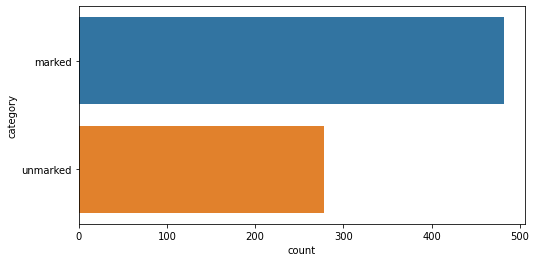

In [36]:
plt.figure(figsize=(8, 4))
sns.countplot(y="category", data=df);

In [40]:
image = cv2.imread(os.path.join("/content/drive/MyDrive/MarkedBeetleImageAnalysis", filenames[0]))
image.shape

(1944, 2592, 3)

In [52]:
def threscrop(img):
  #convert to grayscale and apply adaptive thresholding
  grayscale = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) 
  blur = cv2.GaussianBlur(grayscale,(5,5),0).astype('uint8')
  retval,thresh = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

  #return thresh

  #detect edges and crop the image
  canny = cv2.Canny(thresh, 50, 200)
  pts = np.argwhere(canny > 0)
  y1,x1 = pts.min(axis=0)
  y2,x2 = pts.max(axis=0)
  #cropped_img = img[y1:y2, x1:x2]
  cropped_img = cv2.resize(thresh[y1:y2, x1:x2], (600,600))
  cropped_img = cropped_img.reshape(cropped_img.shape + (1,))



  return cropped_img

In [38]:
def crop(img):

  blurred = cv2.blur(img, (3,3))
  canny = cv2.Canny(blurred, 50, 200)

## find the non-zero min-max coords of canny
  pts = np.argwhere(canny>0)
  y1,x1 = pts.min(axis=0)
  y2,x2 = pts.max(axis=0)

## crop the region
  cropped = img[y1:y2, x1:x2]
  resized=cv2.resize(cropped, (600,600))
  #cv2.imwrite("cropped.png", cropped)
  return resized

  #tagged = cv2.rectangle(img.copy(), (x1,y1), (x2,y2), (0,255,0), 3, cv2.LINE_AA)
  #cv2.imshow("tagged", tagged)
  #cv2.waitKey()

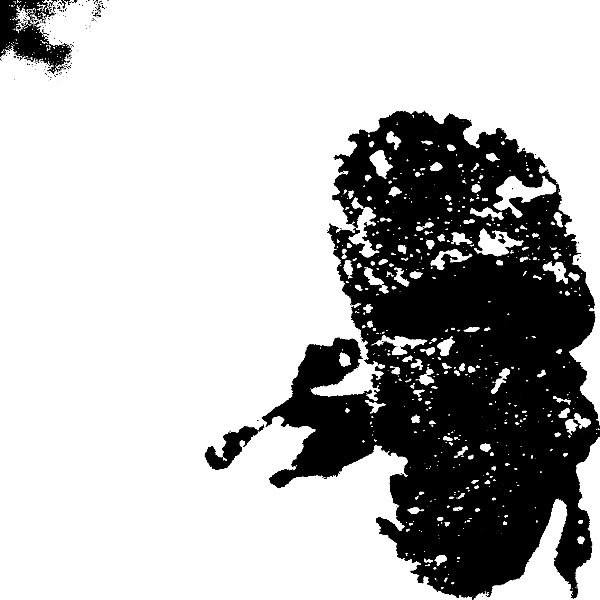

(600, 600, 1)

In [53]:
cv2_imshow(threscrop(image))
threscrop(image).shape

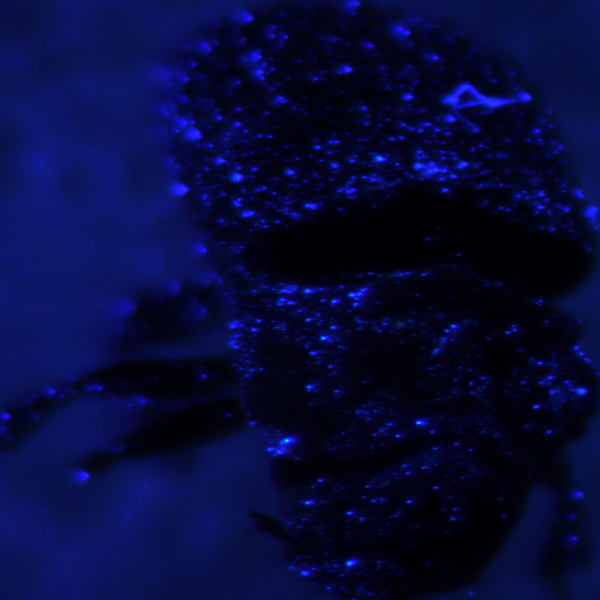

(600, 600, 3)

In [151]:
cv2_imshow(crop(image))
crop(image).shape

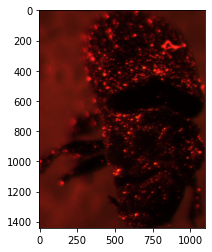

In [ ]:
plt.imshow(crop(image))


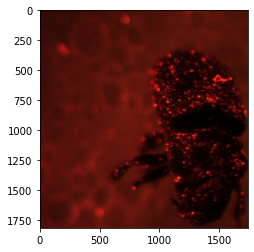

In [ ]:
plt.imshow(threscrop(image))

In [54]:
def visualize_batch(image_ids, labels):
    plt.figure(figsize=(16, 12))
    for ind, (image_id, label) in enumerate(zip(image_ids, labels)):
        plt.subplot(3, 3, ind+1 )
        image = threscrop(cv2.imread(os.path.join("/content/drive/MyDrive/MarkedBeetleImageAnalysis", image_id)))
        #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        plt.imshow(image)
        plt.title(f"{label}", fontsize=12)
        plt.axis("off")
    
    plt.show()

In [55]:
tmp_df = df.sample(9)
tmp_df

,filename,category
667,PaperedMixed39v.tif,marked
31,PaperedControl36v.tif,marked
515,NoPaperedMixed13d.tif,unmarked
728,NoPaperedGreen4d.tif,unmarked
633,PaperedMixed22v.tif,marked
202,PaperedTransparent41v.tif,marked
432,NoPaperedGreen56d.tif,unmarked
485,NoPaperedGreen83v.tif,unmarked
153,PaperedTransparent16d.tif,marked


TypeError: ignored

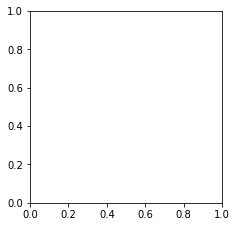

In [56]:
image_ids = tmp_df["filename"].values
labels = tmp_df["category"].values

visualize_batch(image_ids, labels)

In [ ]:
#df["category"] = df["category"].replace({0: 'NotMarked', 1: 'Marked'}) 

In [57]:
train_df, validate_df = train_test_split(df, test_size = 0.10, random_state = 42, stratify = df['category'])
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

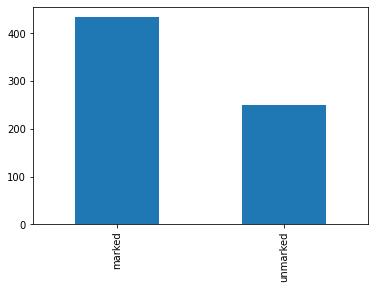

In [58]:
train_df['category'].value_counts().plot.bar()

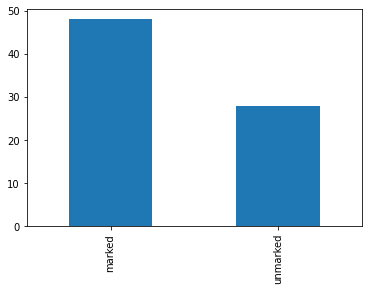

In [59]:
validate_df['category'].value_counts().plot.bar()

In [60]:
IMG_SIZE = 600
size = (IMG_SIZE,IMG_SIZE)
n_CLASS = 2
BATCH_SIZE = 15

In [61]:
datagen_train = ImageDataGenerator(
                    preprocessing_function = threscrop,
                    rotation_range = 40,
                    width_shift_range = 0.2,
                    height_shift_range = 0.2,
                    shear_range = 0.2,
                    zoom_range = 0.2,
                    horizontal_flip = True,
                    vertical_flip = True,
                    fill_mode = 'nearest')


In [62]:
datagen_val = ImageDataGenerator(
                    preprocessing_function = threscrop,
                    )

In [63]:
train_set = datagen_train.flow_from_dataframe(train_df,
                             directory = "/content/drive/MyDrive/MarkedBeetleImageAnalysis",
                             seed=42,
                             x_col = 'filename',
                             y_col = 'category',
                             target_size = size,
                             #color_mode="rgb",
                             class_mode = 'categorical',
                             interpolation = 'nearest',
                             shuffle = True,
                             batch_size = BATCH_SIZE)

Found 684 validated image filenames belonging to 2 classes.


In [64]:
validate_set = datagen_val.flow_from_dataframe(validate_df,
                             directory = "/content/drive/MyDrive/MarkedBeetleImageAnalysis",
                             seed=42,
                             x_col = 'filename',
                             y_col = 'category',
                             target_size = size,
                             #color_mode="rgb",
                             class_mode = 'categorical',
                             interpolation = 'nearest',
                             shuffle = True,
                             batch_size = BATCH_SIZE)

Found 76 validated image filenames belonging to 2 classes.


In [65]:
from keras.models import Sequential
from keras.layers import GlobalAveragePooling2D, Flatten, Dense, Dropout, BatchNormalization, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import RMSprop, Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.applications import EfficientNetB7
from tensorflow.keras import layers

def create_model():
    inputs = layers.Input(shape=(IMG_SIZE,IMG_SIZE, 3))
    #inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE))

    model = EfficientNetB7(include_top=False, input_tensor=inputs, weights="imagenet")
    #model = EfficientNetB7(input_shape = (IMG_SIZE, IMG_SIZE, 3), include_top = False,
                            # weights = 'imagenet',
                             #drop_connect_rate=0.6)
    # Freeze the pretrained weights
    model.trainable = False

    # Rebuild top
    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = layers.Flatten()(x)
    x = layers.BatchNormalization()(x)

    x = layers.Dense(256, activation = 'relu', bias_regularizer=tf.keras.regularizers.L1L2(l1=0.01, l2=0.001))(x)

    top_dropout_rate = 0.5
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    outputs = layers.Dense(2, activation="softmax", name="pred")(x)

    # Compile
    model = tf.keras.Model(inputs, outputs, name="EfficientNet")
    return model

model = create_model()
model.summary()

258088960/258076736 [==============================] - 13s 0us/step
Model: "EfficientNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 600, 600, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 600, 600, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 600, 600, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 601, 601, 3)  0           normalization[0][0]              
___________________

In [66]:
EPOCHS = 5
STEP_SIZE_TRAIN = train_set.n//train_set.batch_size
STEP_SIZE_VALID = validate_set.n//validate_set.batch_size

In [67]:
def Model_fit():
    
    #leaf_model = None
    
    model = create_model()
    
    '''Compiling the model'''
    
    loss = tf.keras.losses.CategoricalCrossentropy(from_logits = False,
                                                   label_smoothing=0.0001,
                                                   name='categorical_crossentropy' )
    
    model.compile(optimizer = Adam(learning_rate = 1e-3),
                        loss = loss, #'categorical_crossentropy'
                        metrics = ['accuracy']) #'acc'
    
        # Stop training when the val_loss has stopped decreasing for 3 epochs.
    stop = EarlyStopping(monitor='val_loss', mode='min', patience=3,
                       restore_best_weights=True, verbose=1)
    
    # Save the model with the minimum validation loss
    checkpoint_cb = ModelCheckpoint("best_model.h5",
                                    save_best_only=True,
                                    monitor = 'val_loss',
                                    mode='min')
    
    # reduce learning rate
    reduce_lr = ReduceLROnPlateau(monitor = 'val_loss',
                                  factor = 0.2,
                                  patience = 2,
                                  min_lr = 1e-6,
                                  mode = 'min',
                                  verbose = 1)
    history = model.fit(train_set,
                             validation_data = validate_set,
                             epochs= EPOCHS,
                             batch_size = BATCH_SIZE,
                             #class_weight = d_class_weights,
                             steps_per_epoch = STEP_SIZE_TRAIN,
                             validation_steps = STEP_SIZE_VALID,
                             callbacks=[stop, checkpoint_cb, reduce_lr])
    model.save('model'+'.h5')  
    return history

In [68]:
results = Model_fit()

Epoch 1/5
45/45 [==============================] - 2522s 55s/step - loss: 1.1400 - accuracy: 0.7085 - val_loss: 0.5216 - val_accuracy: 0.6933


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/5
45/45 [==============================] - 2314s 51s/step - loss: 0.9989 - accuracy: 0.7937 - val_loss: 0.4704 - val_accuracy: 0.7733
Epoch 3/5
45/45 [==============================] - 2354s 52s/step - loss: 0.9694 - accuracy: 0.7803 - val_loss: 0.5163 - val_accuracy: 0.6800
Epoch 4/5
45/45 [==============================] - 2391s 53s/step - loss: 0.9070 - accuracy: 0.7911 - val_loss: 0.3650 - val_accuracy: 0.8400
Epoch 5/5
45/45 [==============================] - 2414s 54s/step - loss: 0.8547 - accuracy: 0.7907 - val_loss: 0.4315 - val_accuracy: 0.8133


In [69]:
print('Train_Cat-Acc: ', max(results.history['accuracy']))
print('Val_Cat-Acc: ', max(results.history['val_accuracy']))

Train_Cat-Acc:  0.7937219738960266
Val_Cat-Acc:  0.8399999737739563


In [70]:
from keras.models import load_model
resultmodel=load_model("model.h5")

In [71]:
resultmodel.save("/content/drive/MyDrive/model_threscrop_epoch5")

INFO:tensorflow:Assets written to: /content/drive/MyDrive/model_threscrop_epoch5/assets


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


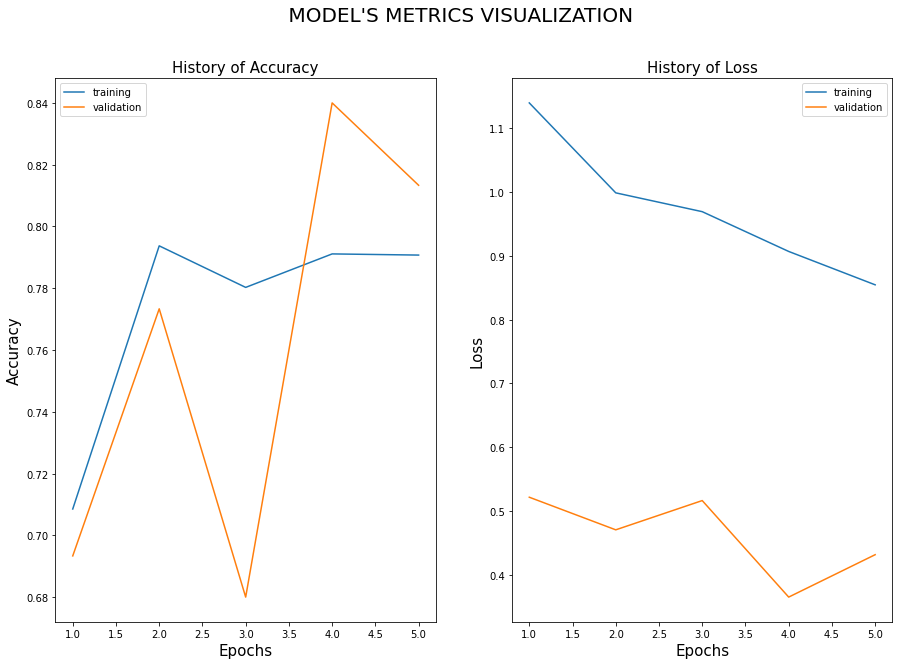

In [72]:
def Train_Val_Plot(acc,val_acc,loss,val_loss):
    
    fig, (ax1, ax2) = plt.subplots(1,2, figsize= (15,10))
    fig.suptitle(" MODEL'S METRICS VISUALIZATION ", fontsize=20)

    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(val_acc) + 1), val_acc)
    ax1.set_title('History of Accuracy', fontsize=15)
    ax1.set_xlabel('Epochs', fontsize=15)
    ax1.set_ylabel('Accuracy', fontsize=15)
    ax1.legend(['training', 'validation'])


    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(val_loss) + 1), val_loss)
    ax2.set_title('History of Loss', fontsize=15)
    ax2.set_xlabel('Epochs', fontsize=15)
    ax2.set_ylabel('Loss', fontsize=15)
    ax2.legend(['training', 'validation'])
    plt.show()
    

Train_Val_Plot(results.history['accuracy'],results.history['val_accuracy'],
               results.history['loss'],results.history['val_loss'])

In [73]:
import keras

final_model = keras.models.load_model('best_model.h5')

In [74]:
tmp_df1=df.sample(10)
tmp_df1

,filename,category
312,PaperedTransparent96v.tif,marked
421,NoPaperedGreen51v.tif,unmarked
372,NoPaperedGreen27d.tif,unmarked
144,PaperedTransparent12v.tif,marked
207,PaperedTransparent43d.tif,marked
525,NoPaperedMixed18v.tif,unmarked
730,NoPaperedGreen5d.tif,unmarked
335,PaperedControlTest81v.tif,marked
157,PaperedTransparent19v.tif,marked
691,NoPaperedMixed1d.tif,unmarked


In [75]:
preds=[]
for image_id in tmp_df1.filename:
  image = Image.open(os.path.join("/content/drive/MyDrive/MarkedBeetleImageAnalysis/",image_id))
  image = image.resize(size)
  image = np.expand_dims(image,axis=0)
  preds.append(np.argmax(final_model.predict(image)))
tmp_df1["prediction"]=preds

In [76]:
tmp_df1["prediction"] = tmp_df1["prediction"].replace({1: 'unmarked', 0: 'marked'}) 
tmp_df1

,filename,category,prediction
312,PaperedTransparent96v.tif,marked,unmarked
421,NoPaperedGreen51v.tif,unmarked,marked
372,NoPaperedGreen27d.tif,unmarked,unmarked
144,PaperedTransparent12v.tif,marked,marked
207,PaperedTransparent43d.tif,marked,unmarked
525,NoPaperedMixed18v.tif,unmarked,unmarked
730,NoPaperedGreen5d.tif,unmarked,unmarked
335,PaperedControlTest81v.tif,marked,marked
157,PaperedTransparent19v.tif,marked,marked
691,NoPaperedMixed1d.tif,unmarked,unmarked
